In [65]:
import random as rnd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import math

def errorify(value):
    error_factors = [0.01,0.1,10,100]
    error_value = value * rnd.choice(error_factors)
    return error_value

def error_price(price):
    return errorify(price)

def error_quantity(quantity):
    return errorify(quantity)

def gen_product(orders_no, price_init, price_end, order_qunat_rng, error_prob, bend):
    price_curr = price_init
    price_diff = (price_end - price_init)
    price_delta = price_diff/orders_no
    product_orders = []
    for i in range(orders_no):
        price = round(price_curr + (rnd.uniform(-0.08,0.08) * price_init), 2)
        quantity = rnd.randrange(order_qunat_rng[0], order_qunat_rng[1])
        if rnd.random() < error_prob:
            if rnd.random() > 0.5:
                price = error_price(price)
            else:
                quantity = error_quantity(quantity)
        product_orders.append((price, quantity))
        price_curr += price_delta * rnd.uniform((i/orders_no), 0.5 + (i/orders_no))

    return product_orders

def gen_products(no_products, no_orders, price_inits, price_ends, order_quant_rngs, error_probs, bends):
    products_x = []
    products_y_price = []
    products_y_quantity = []
    for i in range(no_products):
        product = gen_product(no_orders[i], price_inits[i], price_ends[i], order_quant_rngs[i], error_probs[i], bends[i])
        y_price = [x[0] for x in product]
        y_quantity = [x[1] for x in product]
        products_x.append([x for x in range(no_orders[i])])
        products_y_price.append(y_price)
        products_y_quantity.append(y_quantity)

    return (products_x, products_y_price, products_y_quantity)

def get_coeffs(x, y):
    x_np = np.array(x). reshape((-1,1))
    y_price = np.array(y)
    model_price = LinearRegression().fit(x_np, y_price)

    return (model_price.coef_[0], model_price.intercept_)

def print_with_approx(x, y, coeffs):
    n = len(x)
    plt.scatter(x, y)
    plt.plot([0,n], [coeffs[1], n * coeffs[0] + coeffs[1]])
    plt.show()
    plt.clf()

def remove_outliers(x, y, coeffs):
    n = len(x)
    if n <= 2:
        return (x, y, 0)
    y_exp = [(x * coeffs[0] + coeffs[1]) for x in x]

    SSE = 0

    for i in range(n):
        SSE += (y[i] - y_exp[i])**2

    s = math.sqrt(SSE/(n-2))
    x_good = []
    y_good = []
    outlier_count = 0

    for i in range(n):
        if abs(y[i] - y_exp[i]) < abs(2 * s):
            x_good.append(i)
            y_good.append(y[i])
        else:
            outlier_count += 1

    return (x_good, y_good, outlier_count)

def clean_data(x, y):
    coeffs = get_coeffs(x,y)
    outlier_count = 1
    while outlier_count > 0:
        x, y, outlier_count = remove_outliers(x, y, coeffs)
        coeffs = get_coeffs(x, y)
    
    return (x, y)

def get_diffs(x,y,coeffs):
    n = len(x)
    y_exp = [(x * coeffs[0] + coeffs[1]) for x in x]
    return [y[i] - y_exp[i] for i in range(n)]

def get_threshold(diffs, alpha):
    n = len(diffs)
    diffs_abs = [abs(x) for x in diffs]
    diffs_abs.sort()
    return diffs_abs[math.floor(n * alpha)]

def get_threshold_markov(diffs, alpha):
    n = len(diffs)
    diffs_abs = [abs(x) for x in diffs]
    EX = sum(diffs_abs)/(n-1)
    return EX/(1-alpha)

def get_threshold_chebyshev(diffs, alpha):
    n = len(diffs)
    VarX = sum([x**2 for x in diffs])/n
    return math.sqrt(VarX/(1-alpha))

def check_plausability(x, y, coeffs, threshold):
    y_exp = (x * coeffs[0] + coeffs[1])
    if abs(y - y_exp) > threshold:
        return False
    return True

def print_all_checks(x, y, x_new, y_new, coeffs, alpha):
    diffs = get_diffs(x, y, coeffs)
    markov = check_plausability(x_new, y_new, coeffs, get_threshold_markov(diffs, alpha))
    chebyshev = check_plausability(x_new, y_new, coeffs, get_threshold_chebyshev(diffs, alpha))
    direct = check_plausability(x_new, y_new, coeffs, get_threshold(diffs, alpha))
    print("Markov: " + str(markov))
    print("Chebyshev: " + str(chebyshev))
    print("Direct: " + str(direct))

def check_plausability_all(x, y, x_new, y_new, coeffs):
    diffs = get_diffs(x, y, coeffs)
    markov = check_plausability(x_new, y_new, coeffs, get_threshold_markov(diffs, 0.85))
    chebyshev = check_plausability(x_new, y_new, coeffs, get_threshold_chebyshev(diffs, 0.95))
    direct = check_plausability(x_new, y_new, coeffs, get_threshold(diffs, 0.99))

    if sum([markov, chebyshev, direct]) > 1:
        return True
    return False

def test_plausability(x, y, y_given, coeffs):
    n = len(x)
    diffs = get_diffs(x, y, coeffs)
    s = math.sqrt(sum([x**2 for x in diffs])/(n-2))
    for a in [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]:
        print("a = " + str(a))
        print(check_plausability_all(x, y, x[-1] + 1, y_given + (a * s), coeffs))
        print(check_plausability_all(x, y, x[-1] + 1, y_given - (a * s), coeffs))

# Generacja przykładowych danych

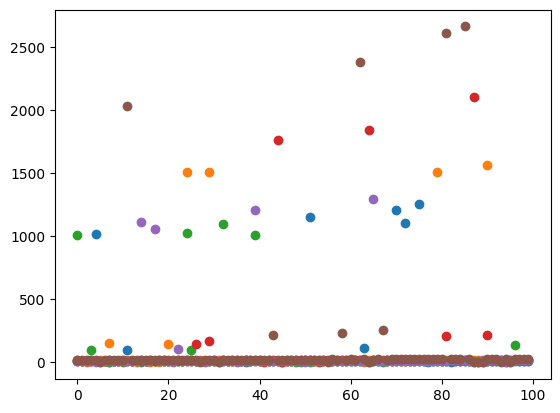

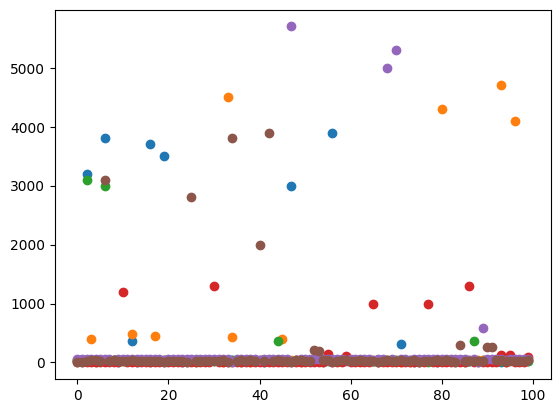

<Figure size 640x480 with 0 Axes>

In [66]:
n = 6
no_orders = [100] * n
price_inits = [10,15,10,15,10,20]
price_ends = [14,17,15,25,20,30]
order_quant_rngs = [(30,40), (40,50), (30,40), (10,15), (50,60), (20,40)]
error_probs = [0.3] * n
bends = [2,1,5,2,1,5]
x_price, y_price, y_quantity = gen_products(n, no_orders, price_inits, price_ends, order_quant_rngs, error_probs, bends)
x_quantity = x_price.copy()
for i in range(n):
    plt.scatter(x_price[i], y_price[i])
plt.show()
plt.clf()
for i in range(n):
    plt.scatter(x_quantity[i], y_quantity[i])
plt.show()
plt.clf()

### Oczyszczanie z użyciem regresji liniowej

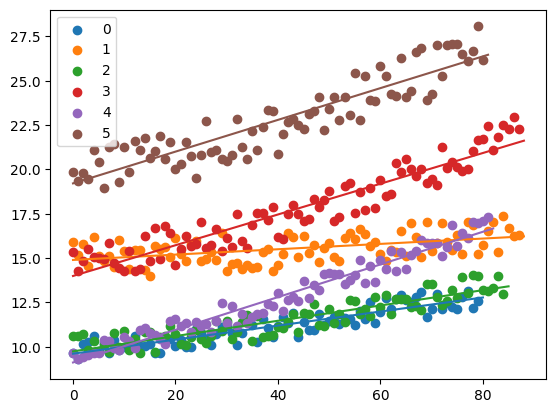

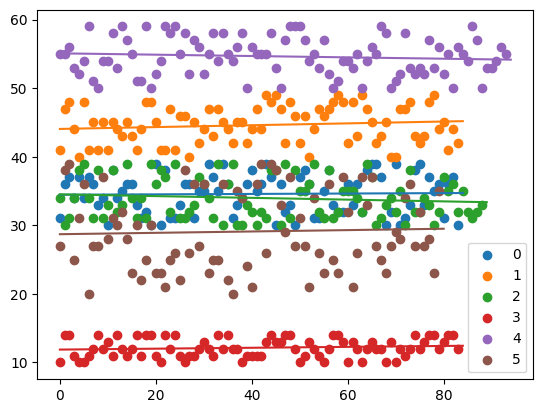

<Figure size 640x480 with 0 Axes>

In [67]:
for i in range(n):
    x_price[i], y_price[i] = clean_data(x_price[i], y_price[i])
    coeffs = get_coeffs(x_price[i],y_price[i])
    plt.scatter(x_price[i], y_price[i], label=f'{i}')
    m = len(x_price[i])
    plt.plot([0,m], [coeffs[1], m * coeffs[0] + coeffs[1]])
plt.legend()
plt.show()
plt.clf()
for i in range(n):
    x_quantity[i], y_quantity[i] = clean_data(x_quantity[i], y_quantity[i])
    coeffs = get_coeffs(x_quantity[i],y_quantity[i])
    plt.scatter(x_quantity[i], y_quantity[i], label=f'{i}')
    m = len(x_quantity[i])
    plt.plot([0,m], [coeffs[1], m * coeffs[0] + coeffs[1]])
plt.legend()
plt.show()
plt.clf()

### Próba sklejania zmiennych na podstawie kąta nachylenia prostej aproksymującej

- szukamy zbiorów danych o podobnym nachyleniu i przesunięciu na osi Y

In [85]:
def check_similarity(coeffs_1, coeffs_2, theta, delta):
    a_angle = abs(math.atan(coeffs_1[0]) - math.atan(coeffs_2[0]))
    # print(a_angle)
    b_quotient = abs(coeffs_1[1]/coeffs_2[1])
    if a_angle < theta and 1 - delta < b_quotient < 1 + delta:
        return True
    return False

def combine_sets(x_a, y_a, x_b, y_b):
    new_set = list(tuple(zip((x_a + x_b), (y_a + y_b))))
    new_set.sort(key=lambda x: x[0])
    new_x = [x[0] for x in new_set]
    new_y = [x[1] for x in new_set]
    return (new_x, new_y)

print("Price:")
for i in range(n):
    for j in range(i+1,n):
        if check_similarity(get_coeffs(x_price[i], y_price[i]), get_coeffs(x_price[j], y_price[j]), 0.04, 0.1):
            print(i, j)

print("Quantity:")
for i in range(n):
    for j in range(i+1,n):
        if check_similarity(get_coeffs(x_quantity[i], y_quantity[i]), get_coeffs(x_quantity[j], y_quantity[j]), 0.04, 0.1):
            print(i, j)

Price:
0 2
Quantity:
0 2
